# ArbitraryDiscretiser + MeanEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding, we create monotonic variables with the target, from those that before were not originally. And this tends to help improve the performance of the linear model. 

## ArbitraryDiscretiser

The ArbitraryDiscretiser() divides continuous numerical variables into contiguous intervals arbitrarily defined by the user.

The user needs to enter a dictionary with variable names as keys, and a list of the limits of the intervals as values. For example {'var1': [0, 10, 100, 1000],'var2': [5, 10, 15, 20]}.

<b>Note:</b> Check out the ArbitraryDiscretiser notebook to learn more about this transformer.

## MeanEncoder

The MeanEncoder() replaces the labels of the variables by the mean value of the target for that label. <br>For example, in the variable colour, if the mean value of the binary target is 0.5 for the label blue, then blue is replaced by 0.5

<b>Note:</b> Read MeanEncoder notebook to know more about this transformer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.encoding import MeanEncoder

plt.rcParams["figure.figsize"] = [15,5]

In [2]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [3]:
data = load_titanic()
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B,S
1,1,1,male,0.9167,1,2,151.5500,C,S
2,1,0,female,2.0000,1,2,151.5500,C,S
3,1,0,male,30.0000,1,2,151.5500,C,S
4,1,0,female,25.0000,1,2,151.5500,C,S


In [4]:
# let's separate into training and testing set
X = data.drop(['survived'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (916, 8)
X_test : (393, 8)


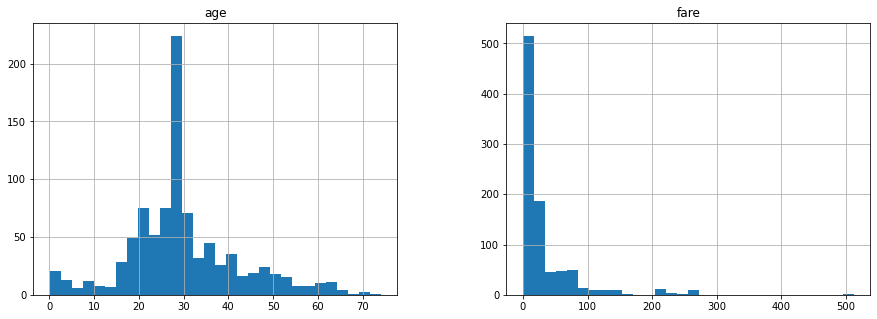

In [5]:
# we will transform two continuous variables
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [6]:
# set up the discretiser
arb_disc = ArbitraryDiscretiser(
    binning_dict={'age': [0, 18, 30, 50, 100],
                  'fare': [-1, 20, 40, 60, 80, 600]},
    # returns values as categorical
    return_object=True)

# set up the mean encoder
mean_enc = MeanEncoder(variables=['age', 'fare'])

# set up the pipeline
transformer = Pipeline(steps=[('ArbitraryDiscretiser', arb_disc),
                              ('MeanEncoder', mean_enc),
                              ])
# train the pipeline
transformer.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ArbitraryDiscretiser',
                 ArbitraryDiscretiser(binning_dict={'age': [0, 18, 30, 50, 100],
                                                    'fare': [-1, 20, 40, 60, 80,
                                                             600]},
                                      return_boundaries=False,
                                      return_object=True)),
                ('MeanEncoder', MeanEncoder(variables=['age', 'fare']))],
         verbose=False)

In [7]:
transformer.named_steps['ArbitraryDiscretiser'].binner_dict_

{'age': [0, 18, 30, 50, 100], 'fare': [-1, 20, 40, 60, 80, 600]}

In [8]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'age': {0: 0.45081967213114754,
  1: 0.34309623430962344,
  2: 0.4262948207171315,
  3: 0.4153846153846154},
 'fare': {0: 0.288135593220339,
  1: 0.43283582089552236,
  2: 0.5636363636363636,
  3: 0.45652173913043476,
  4: 0.7349397590361446}}

In [9]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,3,male,0.426295,0,0,0.288136,n,S
533,2,female,0.343096,0,1,0.432836,n,S
459,2,male,0.426295,1,0,0.432836,n,S
1150,3,male,0.343096,0,0,0.288136,n,S
393,2,male,0.343096,0,0,0.432836,n,S


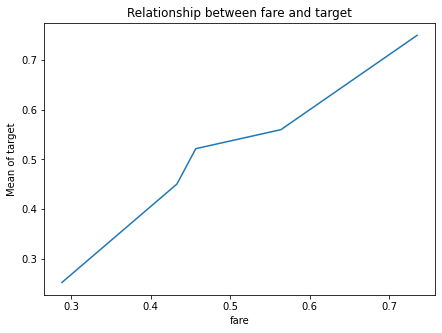

In [10]:
# let's explore the monotonic relationship
plt.figure(figsize=(7, 5))
pd.concat([test_t, y_test], axis=1).groupby("fare")["survived"].mean().plot()
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()

We can observe an almost linear relationship between the variable "fare" after the transformation and the target.